This notebook plots many metrics comparing the performance of the ML and ts_wep zernike estimators.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Error:

For every plot below, $\text{Error} = \sqrt{\sum_i \, (z_i^{pred} - z_i^{true})^2}$, where $z_i$ are zernike coefficients in units of arcseconds.

In [2]:
# load the zernike predictions
tswep_data = np.load("../data/zernike_predictions_ts_wep.npz")
ml_data = np.load("../data/zernike_predictions_ml.npz")

# combine the zernike predictions into the same dictionary
zk_ = {
    "true": tswep_data["z_true"],
    "tswep": tswep_data["z_tswep"],
    "ml": (ml_data["z_ml_intra"] + ml_data["z_ml_extra"]) / 2,
    "ml_intra": ml_data["z_ml_intra"],
    "ml_extra": ml_data["z_ml_extra"],
}

# load the metadata
meta_ = np.load("../data/metadata.npz")

# calculate the initial errors, and identify objects that failed badly
tswep_err_ = np.sqrt(np.sum(np.square(zk_["tswep"] - zk_["true"]), axis=1))
ml_err_ = np.sqrt(np.sum(np.square(zk_["ml"] - zk_["true"]), axis=1))
idx = np.where((tswep_err_ < 2) & (ml_err_ < 2))[0]

# filter out these objects
zk = {key: value[idx] for key, value in zk_.items()}
meta = {key: value[idx] for key, value in meta_.items()}

# calculate the errors one more time
tswep_err = np.sqrt(np.sum(np.square(zk["tswep"] - zk["true"]), axis=1))
ml_err = np.sqrt(np.sum(np.square(zk["ml"] - zk["true"]), axis=1))

### 1. Error histogram

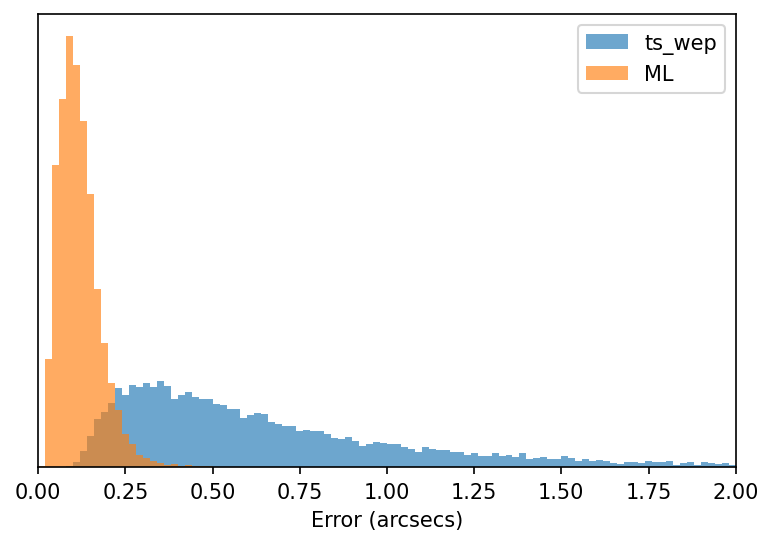

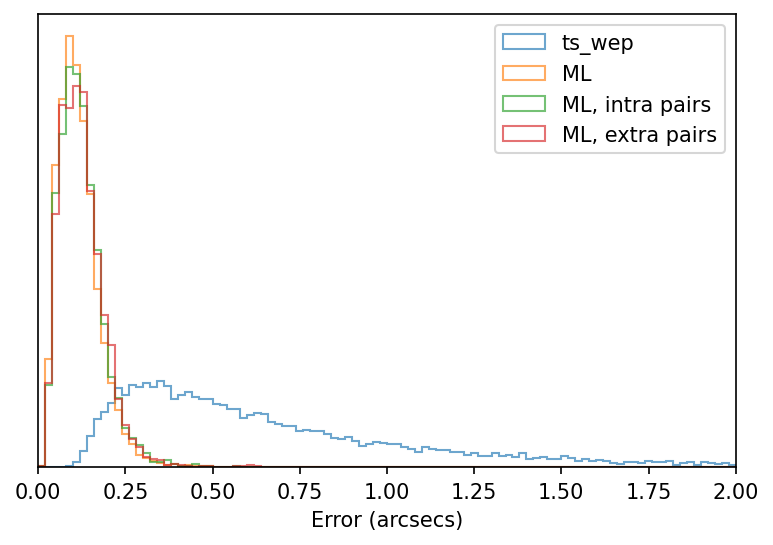

In [3]:
# plot a histogram of the errors
fig, ax = plt.subplots(dpi=150)

hist_settings = {
    "range": (0, 2),
    "bins": 100,
    "histtype": "stepfilled", 
    "alpha": 0.65,
    "density": True,
}
ax.hist(tswep_err, **hist_settings, label="ts_wep")
ax.hist(ml_err, **hist_settings, label="ML")
ax.legend()

ax.set(xlabel="Error (arcsecs)", xlim=hist_settings["range"], yticks=[])

# now calculate errors using intra- and extra-focal pairings
intra_err = []
extra_err = []
for i in range(0, len(meta["pntId"])-1, 2):
    if (
        meta["pntId"][i] == meta["pntId"][i+1] and
        meta["sensor"][i] == meta["sensor"][i+1]
    ):
        intra_z = (zk["ml_intra"][i] + zk["ml_intra"][i+1]) / 2
        intra_err.append(np.sqrt(np.sum(np.square(intra_z - zk["true"][i]))))
        
        extra_z = (zk["ml_extra"][i] + zk["ml_extra"][i+1]) / 2
        extra_err.append(np.sqrt(np.sum(np.square(extra_z - zk["true"][i]))))
intra_err = np.array(intra_err)
extra_err = np.array(extra_err)

# make a second histogram, comparing the intra- and extra-only errors
fig, ax = plt.subplots(dpi=150)
hist_settings["histtype"] = "step" 

ax.hist(tswep_err, **hist_settings, label="ts_wep")
ax.hist(ml_err, **hist_settings, label="ML")
ax.hist(intra_err, **hist_settings, label="ML, intra pairs")
ax.hist(extra_err, **hist_settings, label="ML, extra pairs")

ax.legend()
ax.set(xlabel="Error (arcsecs)", xlim=hist_settings["range"], yticks=[])

plt.show()

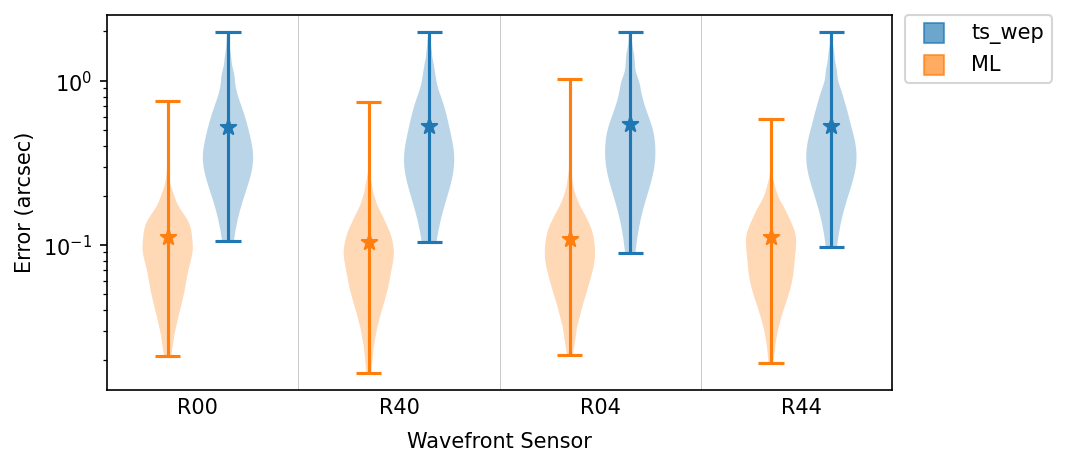

In [4]:
# sort the errors by sensor
sensors = ["R00", "R40", "R04", "R44"]
tswep_err_by_sensor = [tswep_err[meta["sensor"] == sensor] for sensor in sensors]
ml_err_by_sensor = [ml_err[meta["sensor"] == sensor] for sensor in sensors]


fig, (ax, leg) = plt.subplots(
    1, 2, figsize=(7, 3), dpi=150, gridspec_kw={"width_ratios":[8, 1]}, constrained_layout=True
)

# create a violin plot of the errors per-sensor
positions = np.arange(1, len(sensors) + 1)
ax.violinplot(tswep_err_by_sensor, positions=positions+0.15, widths=0.25)
ax.violinplot(ml_err_by_sensor, positions=positions-0.15, widths=0.25)

# plot the medians as stars
ax.scatter(
    positions+0.15,
    [np.median(sensor) for sensor in tswep_err_by_sensor],
    marker="*",
    s=60,
)
ax.scatter(
    positions-0.15,
    [np.median(sensor) for sensor in ml_err_by_sensor],
    marker="*",
    s=60,
)

# setup labels
ax.set(
    xlabel="Wavefront Sensor",
    xticks=positions,
    xticklabels=sensors,
    ylabel="Error (arcsec)", 
    yscale="log",
)
ax.xaxis.labelpad = 7
ax.tick_params(axis="x", length=0)

# silver lines between panels
for i in positions[:-1]:
    ax.axvline(i+0.5, c="silver", ls="-", lw=0.4, zorder=0)
    
# create the legend
leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="ts_wep")
leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="ML")
leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg.axis("off")

fig.savefig("../figures/error_by_sensor.png")

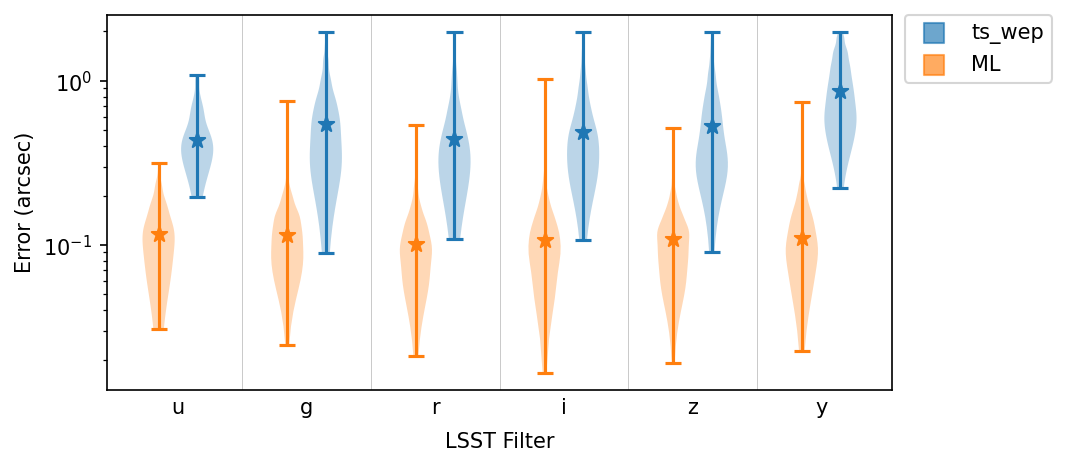

In [5]:
# sort the errors by sensor
filters = list("ugrizy")
tswep_err_by_filter = [tswep_err[meta["lsst_filter"] == f] for f in filters]
ml_err_by_filter = [ml_err[meta["lsst_filter"] == f] for f in filters]


fig, (ax, leg) = plt.subplots(
    1, 2, figsize=(7, 3), dpi=150, gridspec_kw={"width_ratios":[8, 1]}, constrained_layout=True
)

# create a violin plot of the errors per-sensor
positions = np.arange(1, len(filters) + 1)
ax.violinplot(tswep_err_by_filter, positions=positions+0.15, widths=0.25)
ax.violinplot(ml_err_by_filter, positions=positions-0.15, widths=0.25)

# plot the medians as stars
ax.scatter(
    positions+0.15,
    [np.median(f) for f in tswep_err_by_filter],
    marker="*",
    s=60,
)
ax.scatter(
    positions-0.15,
    [np.median(f) for f in ml_err_by_filter],
    marker="*",
    s=60,
)

# setup labels
ax.set(
    xlabel="LSST Filter",
    xticks=positions,
    xticklabels=filters,
    ylabel="Error (arcsec)", 
    yscale="log",
)
ax.xaxis.labelpad = 7
ax.tick_params(axis="x", length=0)

# silver lines between panels
for i in positions[:-1]:
    ax.axvline(i+0.5, c="silver", ls="-", lw=0.4, zorder=0)
    
# create the legend
leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="ts_wep")
leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="ML")
leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg.axis("off")

fig.savefig("../figures/error_by_filter.png")

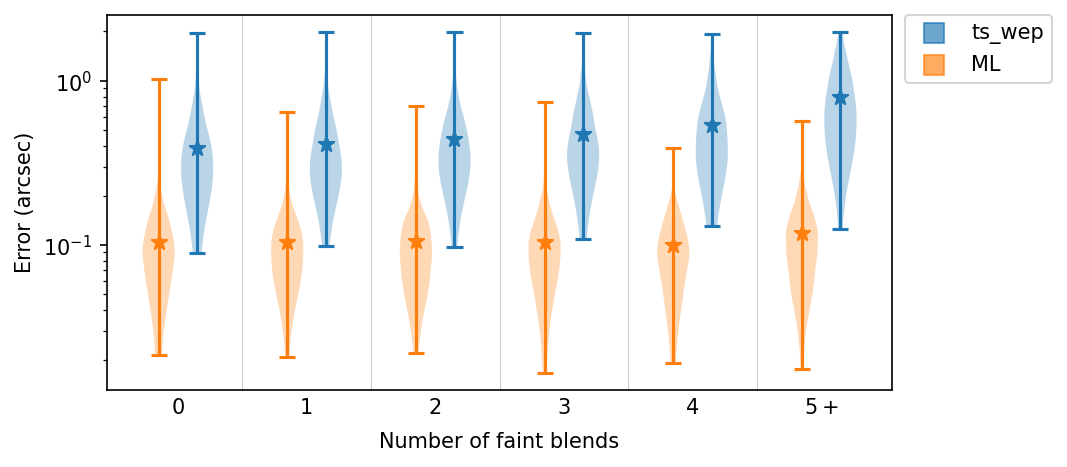

In [6]:
# sort the errors by faint blends
nblends = np.max((meta["intra_faint_blends"], meta["extra_faint_blends"]), axis=0)
tswep_err_by_blend = []
ml_err_by_blend = []
for i in range(5):
    tswep_err_by_blend.append(tswep_err[nblends == i])
    ml_err_by_blend.append(ml_err[nblends == i])
tswep_err_by_blend.append(tswep_err[nblends >=5])
ml_err_by_blend.append(ml_err[nblends >=5])


fig, (ax, leg) = plt.subplots(
    1, 2, figsize=(7, 3), dpi=150, gridspec_kw={"width_ratios":[8, 1]}, constrained_layout=True
)

# create a violin plot of the errors per-sensor
positions = np.arange(len(tswep_err_by_blend))
ax.violinplot(tswep_err_by_blend, positions=positions+0.15, widths=0.25)
ax.violinplot(ml_err_by_blend, positions=positions-0.15, widths=0.25)

# plot the medians as stars
ax.scatter(
    positions+0.15,
    [np.median(f) for f in tswep_err_by_blend],
    marker="*",
    s=60,
)
ax.scatter(
    positions-0.15,
    [np.median(f) for f in ml_err_by_blend],
    marker="*",
    s=60,
)

# setup labels
ax.set(
    xlabel="Number of faint blends",
    xticks=positions,
    xticklabels=list(np.arange(0, 5)) + ["$5+$"],
    ylabel="Error (arcsec)", 
    yscale="log",
)
ax.xaxis.labelpad = 7
ax.tick_params(axis="x", length=0)

# silver lines between panels
for i in positions[:-1]:
    ax.axvline(i+0.5, c="silver", ls="-", lw=0.4, zorder=0)
    
# create the legend
leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="ts_wep")
leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="ML")
leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg.axis("off")

fig.savefig("../figures/error_by_faint_blends.png")

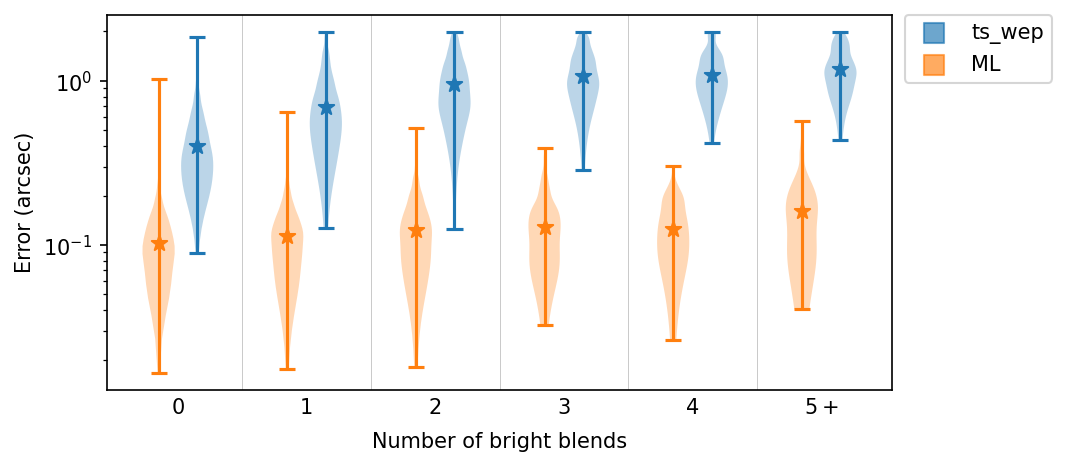

In [7]:
# sort the errors by bright blends
nblends = np.max((meta["intra_bright_blends"], meta["extra_bright_blends"]), axis=0)
tswep_err_by_blend = []
ml_err_by_blend = []
for i in range(5):
    tswep_err_by_blend.append(tswep_err[nblends == i])
    ml_err_by_blend.append(ml_err[nblends == i])
tswep_err_by_blend.append(tswep_err[nblends >=5])
ml_err_by_blend.append(ml_err[nblends >=5])


fig, (ax, leg) = plt.subplots(
    1, 2, figsize=(7, 3), dpi=150, gridspec_kw={"width_ratios":[8, 1]}, constrained_layout=True
)

# create a violin plot of the errors per-sensor
positions = np.arange(len(tswep_err_by_blend))
ax.violinplot(tswep_err_by_blend, positions=positions+0.15, widths=0.25)
ax.violinplot(ml_err_by_blend, positions=positions-0.15, widths=0.25)

# plot the medians as stars
ax.scatter(
    positions+0.15,
    [np.median(f) for f in tswep_err_by_blend],
    marker="*",
    s=60,
)
ax.scatter(
    positions-0.15,
    [np.median(f) for f in ml_err_by_blend],
    marker="*",
    s=60,
)

# setup labels
ax.set(
    xlabel="Number of bright blends",
    xticks=positions,
    xticklabels=list(np.arange(0, 5)) + ["$5+$"],
    ylabel="Error (arcsec)", 
    yscale="log",
)
ax.xaxis.labelpad = 7
ax.tick_params(axis="x", length=0)

# silver lines between panels
for i in positions[:-1]:
    ax.axvline(i+0.5, c="silver", ls="-", lw=0.4, zorder=0)
    
# create the legend
leg.scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="ts_wep")
leg.scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="ML")
leg.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
leg.axis("off")

fig.savefig("../figures/error_by_bright_blends.png")

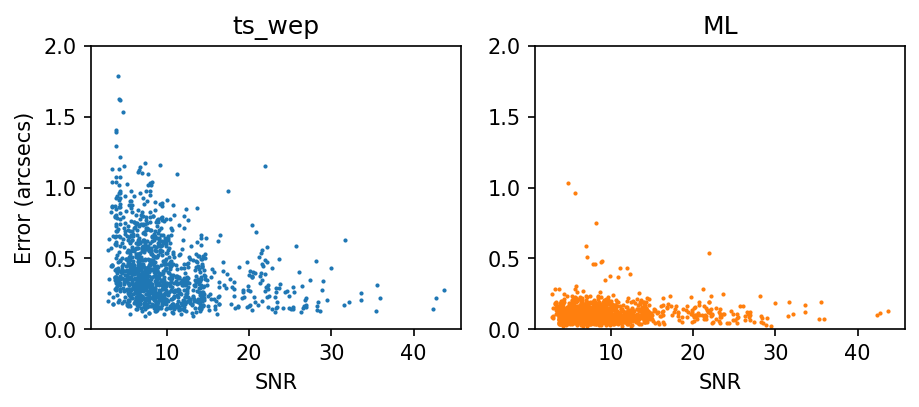

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=150)

snr = np.min((meta["intra_snr"], meta["extra_snr"]), axis=0)
ax1.scatter(snr, tswep_err, s=1, c="C0")
ax2.scatter(snr, ml_err, s=1, c="C1")

ax1.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="SNR", ylabel="Error (arcsecs)", title="ts_wep")
ax2.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="SNR", title="ML")

fig.savefig("../figures/error_vs_snr.png")

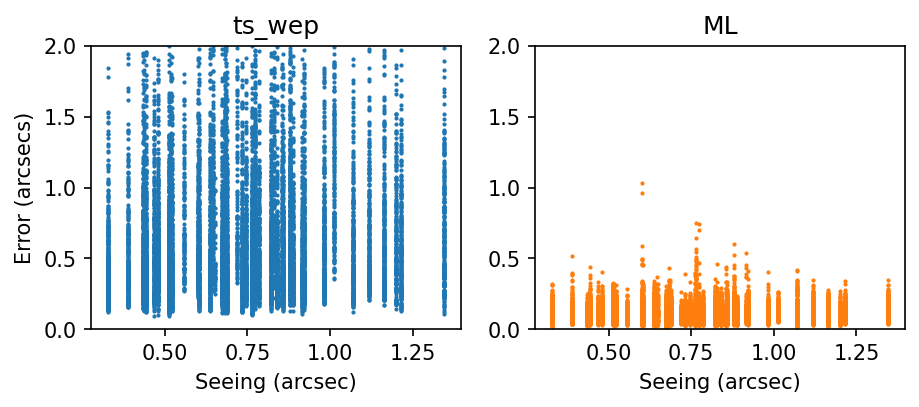

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=150)

ax1.scatter(meta["seeing"], tswep_err, s=1, c="C0")
ax2.scatter(meta["seeing"], ml_err, s=1, c="C1")

ax1.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="Seeing (arcsec)", ylabel="Error (arcsecs)", title="ts_wep")
ax2.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="Seeing (arcsec)", title="ML")

fig.savefig("../figures/error_vs_seeing.png")

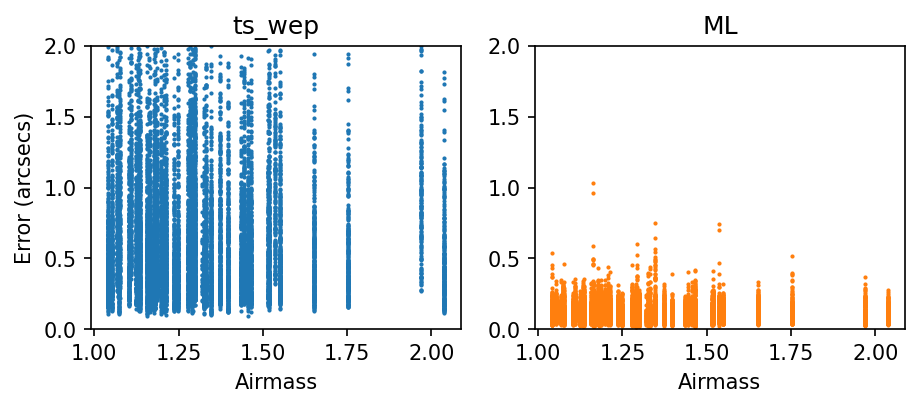

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=150)

ax1.scatter(meta["airmass"], tswep_err, s=1, c="C0")
ax2.scatter(meta["airmass"], ml_err, s=1, c="C1")

ax1.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="Airmass", ylabel="Error (arcsecs)", title="ts_wep")
ax2.set(yticks=np.arange(0, 2.5, 0.5), ylim=(0,2), xlabel="Airmass", title="ML")

fig.savefig("../figures/error_vs_airmass.png")

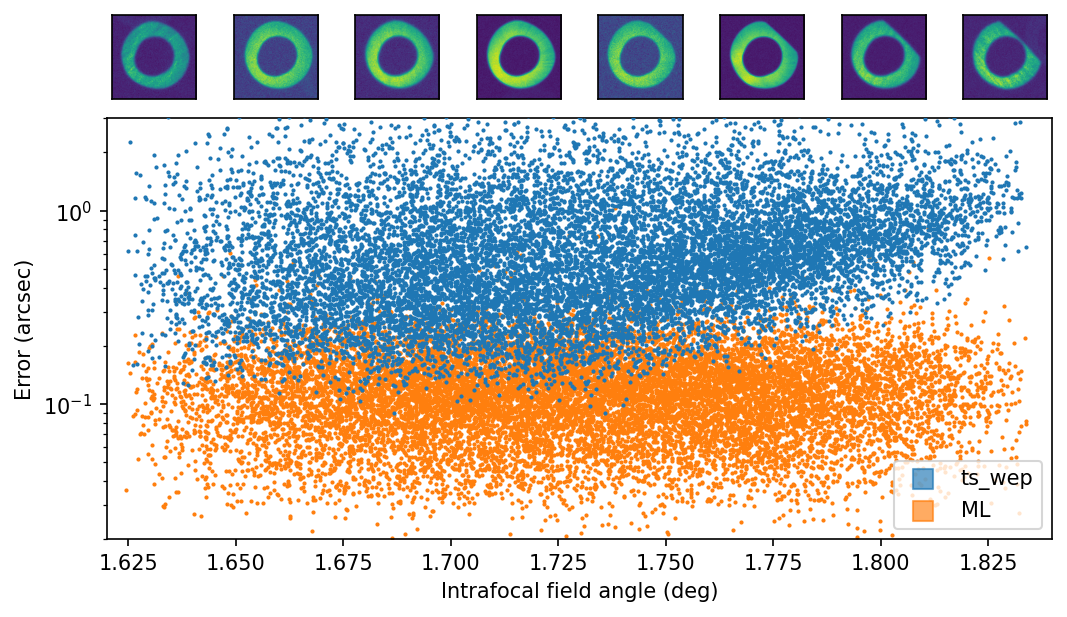

In [11]:
fig, axes = plt.subplot_mosaic(
    """
    abcdefgh
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    zzzzzzzz
    """,
    figsize=(7, 4), dpi=150,
    constrained_layout=True,
)

# write a function for plotting images above angles
def plot_img(ax, angle, nrot):
    # identify the closest star
    idx = np.argmin(np.abs(meta_["field_angle"] - angle))
    
    # load the image
    pnt = meta_["pntId"][idx]
    obs = meta_["obsId"][idx]
    obj = meta_["intraObjId"][idx]
    img = np.load(f"/astro/store/epyc/users/jfc20/aos_sims/images/pnt{pnt}.obs{obs}.obj{obj}.image.npy")
    
    # rotate the image nrot times
    for i in range(nrot):
        img = np.rot90(img)
    
    # plot the image
    ax.imshow(img, origin="lower")
    ax.set(xticks=[], yticks=[])

# plot images at a range of different angles
plot_img(axes["a"], 1.6320, 2)
plot_img(axes["b"], 1.6600, 0)
plot_img(axes["c"], 1.6910, 0)
plot_img(axes["d"], 1.7160, 3)
plot_img(axes["e"], 1.7460, 3)
plot_img(axes["f"], 1.7730, 3)
plot_img(axes["g"], 1.8005, 3)
plot_img(axes["h"], 1.8300, 1)

# plot the error vs field angle
axes["z"].scatter(meta_["field_angle"], tswep_err_, s=1, zorder=10)
axes["z"].scatter(meta_["field_angle"], ml_err_, s=1)

# labels
axes["z"].set(xlabel="Intrafocal field angle (deg)", ylabel="Error (arcsec)", yscale="log", xlim=(1.62, 1.84), ylim=(2e-2, 3e0))
axes["z"].scatter([], [], c="C0", marker="s", s=100, alpha=0.65, label="ts_wep")
axes["z"].scatter([], [], c="C1", marker="s", s=100, alpha=0.65, label="ML")
axes["z"].legend(loc="lower right")

fig.savefig("../figures/error_vs_angle.png")